In [1]:
# Import Libraries:

import numpy as np
import pandas as pd
import seaborn as sn
import xgboost as xgb
import lightgbm as lgb

import matplotlib
import matplotlib.pyplot as plt
#import graphviz
import shap
import sklearn

from sklearn import ensemble
from sklearn.inspection import plot_partial_dependence
from matplotlib.colors import ListedColormap
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from IPython.display import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from scipy import stats


# Susceptibility to induced seismicity 

## Geoscience BC project

In [2]:
df_GHFraw = pd.read_csv('Geological_Operational_Likelihood.csv')


# Exploratory Data Analysis (EDA)

In [3]:
df_GHFraw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 44 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Well_ID                 4410 non-null   int64  
 1   LATITUDE                4410 non-null   float64
 2   LONGITUDE               4410 non-null   float64
 3   Max_Injection_Pressure  3657 non-null   float64
 4   Avg_rate                3736 non-null   float64
 5   Active_Days             4408 non-null   float64
 6   Total_Propant           4374 non-null   float64
 7   Avg_Propant/Stage       4374 non-null   float64
 8   Total_Volume            4374 non-null   float64
 9   Avg_Volume/Stage        4374 non-null   float64
 10  Number_Stages           4379 non-null   float64
 11  Complition_Length       3546 non-null   float64
 12  Avg_Frac_Spacing        3520 non-null   float64
 13  Avg_Vol/Meter           3545 non-null   float64
 14  Avg_Propant/Meter       3544 non-null   

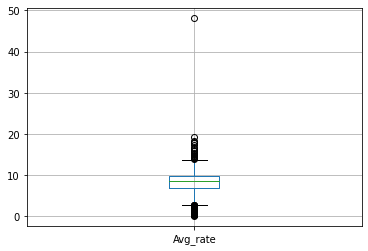

In [4]:
boxplot = df_GHFraw.boxplot(column=['Avg_rate'])

In [3]:
imputer = SimpleImputer(strategy="median")
imputer.fit(df_GHFraw)
df_GHF_imp = imputer.transform(df_GHFraw)

In [35]:
df_GHFraw.shape

(4410, 44)

In [36]:
df_GHF_imp.shape

(4410, 44)

In [4]:
df_GHF_imp = pd.DataFrame(df_GHF_imp, columns = df_GHFraw.columns)

In [5]:
df_GHF_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Well_ID                 4410 non-null   float64
 1   LATITUDE                4410 non-null   float64
 2   LONGITUDE               4410 non-null   float64
 3   Max_Injection_Pressure  4410 non-null   float64
 4   Avg_rate                4410 non-null   float64
 5   Active_Days             4410 non-null   float64
 6   Total_Propant           4410 non-null   float64
 7   Avg_Propant/Stage       4410 non-null   float64
 8   Total_Volume            4410 non-null   float64
 9   Avg_Volume/Stage        4410 non-null   float64
 10  Number_Stages           4410 non-null   float64
 11  Complition_Length       4410 non-null   float64
 12  Avg_Frac_Spacing        4410 non-null   float64
 13  Avg_Vol/Meter           4410 non-null   float64
 14  Avg_Propant/Meter       4410 non-null   

In [5]:
z_scores = stats.zscore(df_GHF_imp)  #calculate z-scores of `df`

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_GHF = df_GHF_imp[filtered_entries]

In [7]:
df_GHF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3353 entries, 1 to 4409
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Well_ID                 3353 non-null   float64
 1   LATITUDE                3353 non-null   float64
 2   LONGITUDE               3353 non-null   float64
 3   Max_Injection_Pressure  3353 non-null   float64
 4   Avg_rate                3353 non-null   float64
 5   Active_Days             3353 non-null   float64
 6   Total_Propant           3353 non-null   float64
 7   Avg_Propant/Stage       3353 non-null   float64
 8   Total_Volume            3353 non-null   float64
 9   Avg_Volume/Stage        3353 non-null   float64
 10  Number_Stages           3353 non-null   float64
 11  Complition_Length       3353 non-null   float64
 12  Avg_Frac_Spacing        3353 non-null   float64
 13  Avg_Vol/Meter           3353 non-null   float64
 14  Avg_Propant/Meter       3353 non-null   

In [6]:
plot_df = df_GHF.drop(columns=['Well_Shmax_Azdiff','Shmin-Mpa','Bulk_Density','PP_grad','b_value','Max_Pb','Avg_rate','Gamma_Ray','Avg_Vol/Meter','Avg_Propant/Meter','Avg_Propant/Stage','Avg_Volume/Stage','Total_Propant','TVD','Number_Stages','Active_Days','Well_ID', 'LATITUDE','LONGITUDE','MiddleMontney','Lower_Form','Dist_MidMon','Dist_Lower_Form','WellDensity-5km','Shear_Strain','WellDensity-3km','Shmax_variation','Max_ISIP','Dist_CTB','Mon_Thickness','Dist_Faults','Basement_Top','Montney-Top','Dist_Basement','Dist_TopMon','WellDensity-10km','WellDensity-1km'])

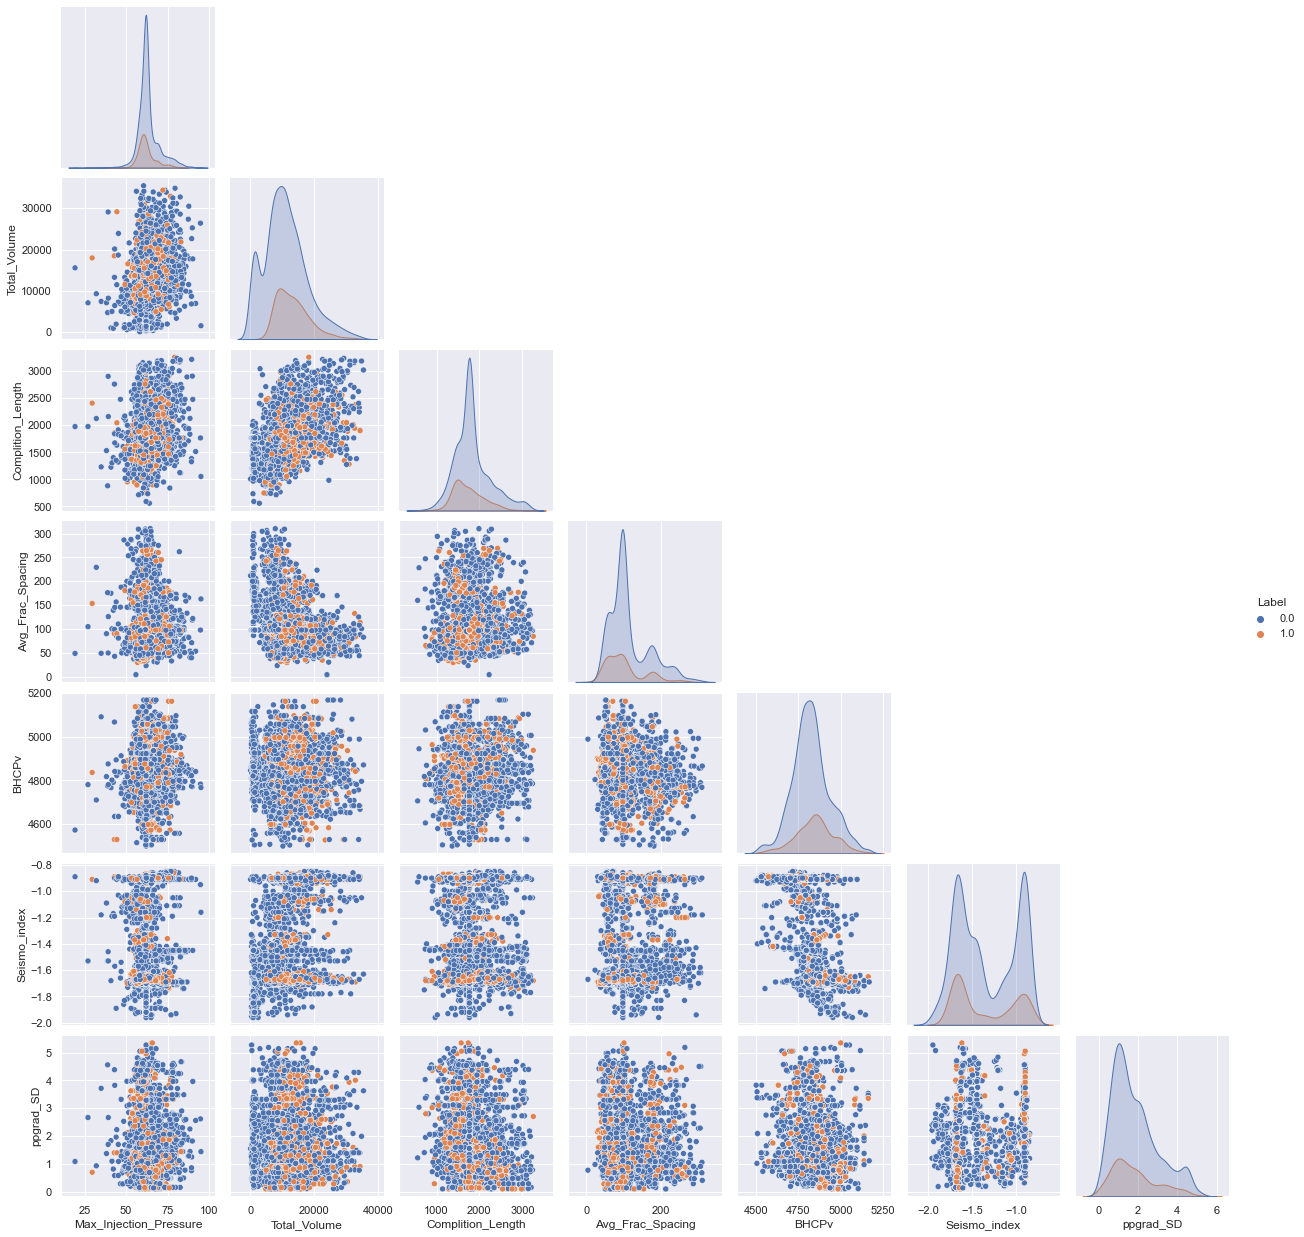

In [9]:
sn.set(font_scale=1) 
sns_plot = sn.pairplot(plot_df, hue="Label", corner=True)
sns_plot.savefig('pairplot_200dpi_ss.png',dpi = 200)

## Correlation Matrix

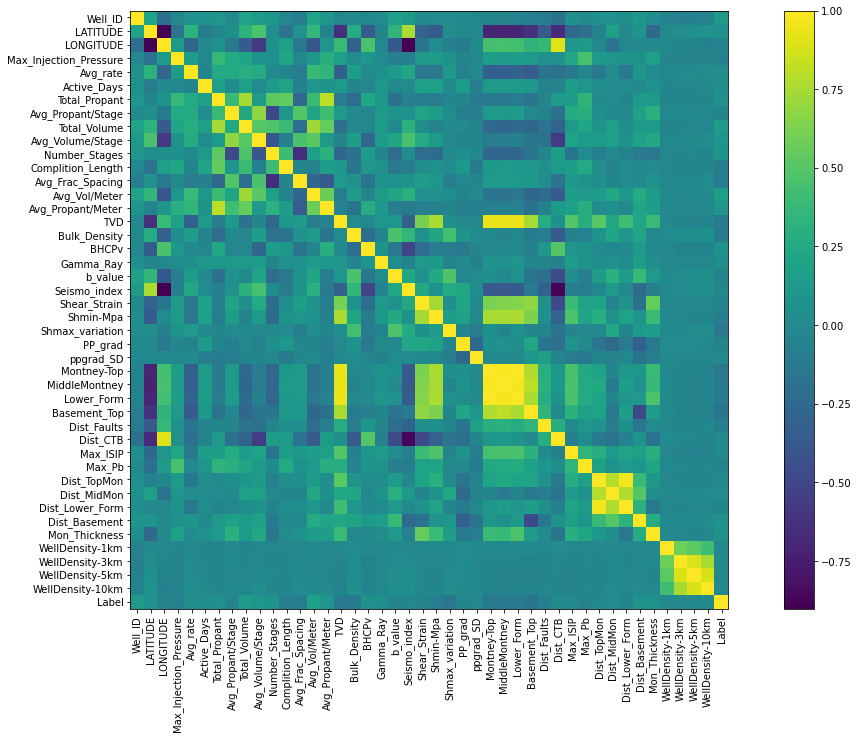

In [46]:
fig = plt.figure(figsize=(20,11))
ax1 = fig.add_subplot(111)
plt.imshow(df_GHF.corr())
plt.colorbar()
labels = df_GHF.columns.tolist()
ax1.set_xticks(np.arange(len(labels)))
ax1.set_yticks(np.arange(len(labels)))
ax1.set_xticklabels(labels,rotation=90, fontsize=10)
ax1.set_yticklabels(labels,fontsize=10)
plt.show()
fig.savefig('Corr_coef_L.png', dpi=300)

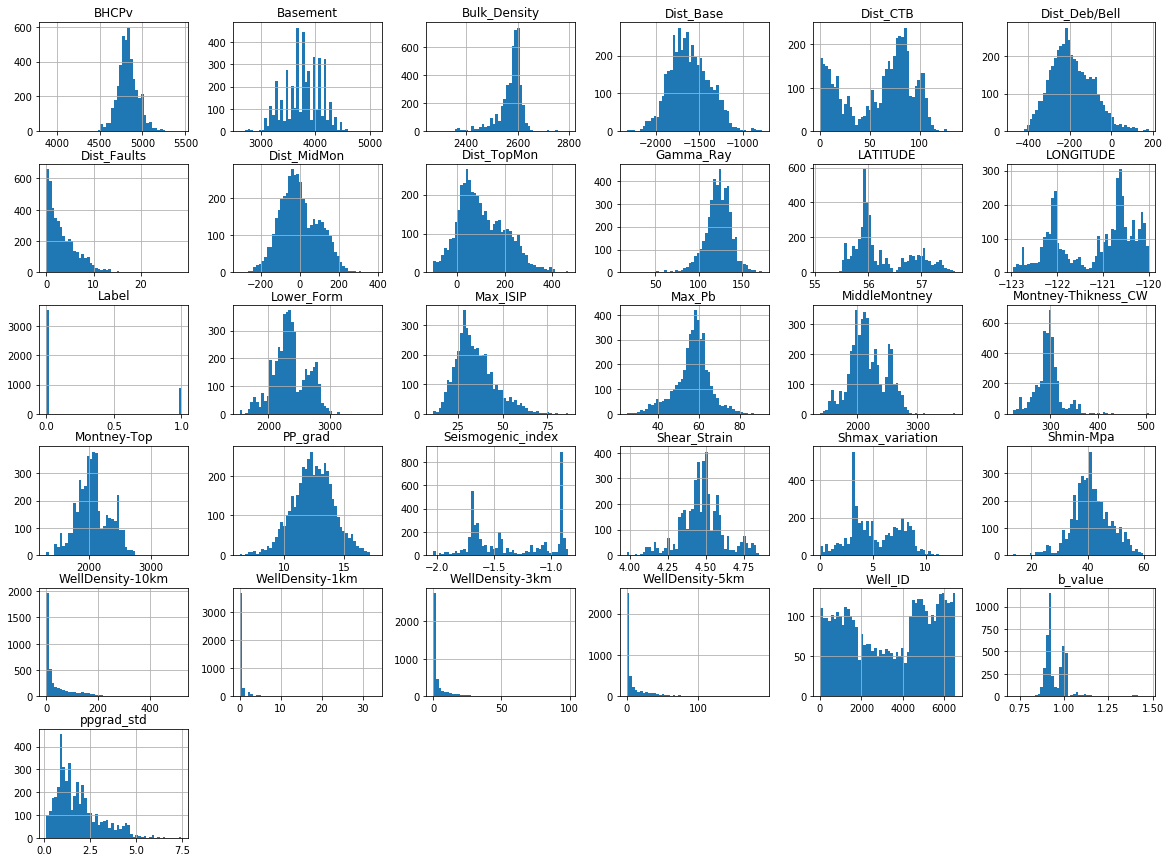

In [6]:
df_well.hist(bins=50, figsize=(20, 15));